# Overview

Here we present the results using our standard training regiment, which looks like:

```python
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
```

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [4]:
torch.cuda.set_device(2)

In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Training [O/H] 50th percentile with $gri$ images only using single regiment

In [4]:
train_label_csv = f'{PATH}/catalogs/train-oh_p50.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)


In [5]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [6]:
# train-val permutation
all_idxs = np.random.permutation(range(n))

# params
sz = 128
bs = 128
arch = resnet34

In [10]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.165427   0.186054  
    1      0.159281   0.13543                                  



epoch      trn_loss   val_loss                                 
    0      0.13631    0.125786  



epoch      trn_loss   val_loss                                  
    0      0.092925   0.087836  
    1      0.106972   0.095564                                 
    2      0.091273   0.086135                                  
    3      0.118223   0.091112                                 
    4      0.103651   0.117282                                  
    5      0.093439   0.08877                                   
    6      0.088848   0.084301                                  



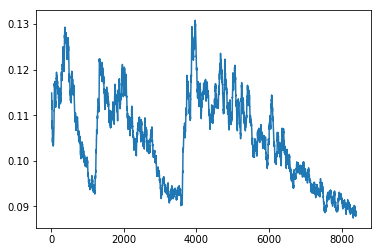

In [8]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

This took ~30 minutes

In [11]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

# Evaluate predictions

## Test set with TTA

In [12]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

In [11]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0)
y_test = df_test.loc[test_names].values

Save these out by calling
```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions-oh_p50.csv')
```

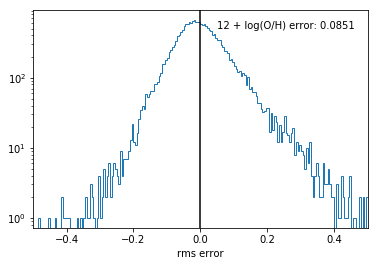

In [14]:
rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

plt.hist(p_test[:,0]-y_test[:,0], bins=200, histtype='step', range=[-0.5, 0.5]);
plt.text(0.05, 500, f'12 + log(O/H) error: {rms_errors:.4f}')
plt.xlim(-0.5, 0.5)
plt.axvline(0, c='k')
plt.yscale('log')
plt.xlabel('rms error');

## Plot binned predictions

In [16]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

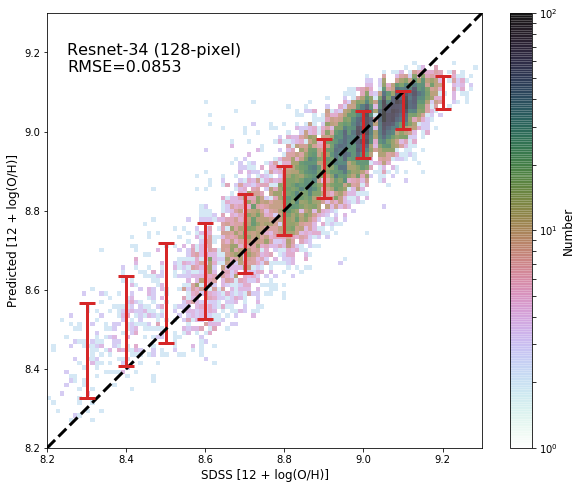

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS [12 + log(O/H)]', fontsize=12)
ax.set_ylabel('Predicted [12 + log(O/H)]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')

## Plot marginal RMSE

In [26]:
def plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors):
    
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    *_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=1)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    
    ax.set_xlabel('SDSS [12 + log(O/H)]', fontsize=14)
    ax.set_ylabel('Predicted [12 + log(O/H)]', fontsize=14)
    
    ax.text(8.25, 9.15, f'Resnet-34 \n' f'{sz} $\\times$ {sz}', fontsize=16)
    
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 19:])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=14)
    
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:3, 2:18])

    y_bins = np.linspace(8.3, 9.2, 10)
    rmse_bins = [np.sqrt(np.mean(((p_test - y_test)[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)])**2)) for y in y_bins]
    ax_marg.plot(y_bins, rmse_bins, marker='o', c='C0', ls='', markersize=10)
    
    ax_marg.set_ylabel('RMSE', fontsize=14)
    ax_marg.set_ylim(0, 0.3)
    ax_marg.set_xlim(8.2, 9.3)
    
    # include mean RMSE  
    ax_marg.axhline(rms_errors, ls='-', c='k')
    ax_marg.text(8.9, 0.15, f'<RMSE>={rms_errors:.4f}', fontsize=14)

    fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS_with-marginals.pdf')
    


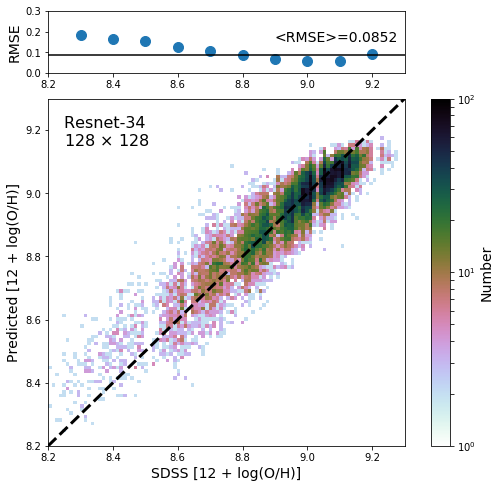

In [20]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

## marginal NMAD

In [24]:
def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*np.median(np.abs(z - np.median(z)))

def rmse_np(x, y):
    return np.sqrt(np.mean((y - x)**2))

In [93]:
def plot_comparison_with_marginals(y_test, p_test):
    
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    *_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=1)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    
    ax.set_xlabel('SDSS [12 + log(O/H)]', fontsize=14)
    ax.set_ylabel('Predicted [12 + log(O/H)]', fontsize=14)
    
    ax.text(8.25, 9.15, f'Resnet-34 \n' f'{sz} $\\times$ {sz}', fontsize=16)
    
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 19:])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=14)
    
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.linspace(8.3, 9.2, 10)
    rmse_bins = [np.sqrt(np.mean(((p_test - y_test)[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)])**2)) for y in y_bins]
    num_in_bins = np.sum([(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05) for y in y_bins], axis=1)
    rmse_error = rmse_np(p_test, y_test)
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'<RMSE>={rmse_error:.4f}')

    nmad_bins = [np.sqrt(nmad(((p_test - y_test)[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)])**2)) for y in y_bins]
    nmad_error = nmad(p_test - y_test)
    ax_marg.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'<NMAD>={nmad_error:.4f}')
    
    ax_marg.set_ylabel('Residual\nscatter', fontsize=14)
    ax_marg.legend(fontsize=12, framealpha=0.0, frameon=False)
    ax_marg.set_ylim(0, 0.3)
    ax_marg.set_xlim(8.2, 9.3)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', c='C0')
    ax_marg.axhline(nmad_error, ls='-', c='C1')
    
    fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS_with-marginals.pdf', dpi=300)
    


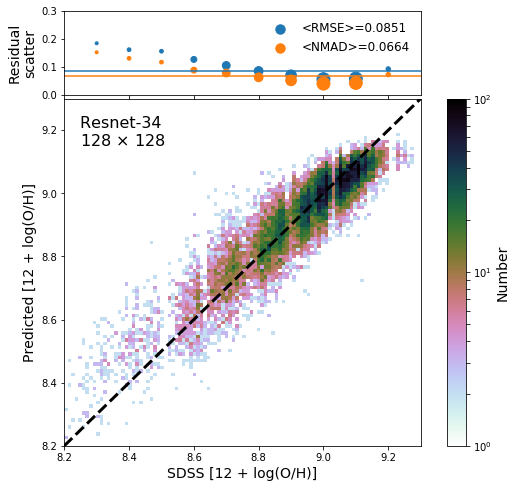

In [94]:
plot_comparison_with_marginals(y_test, p_test)

# 64 x 64 $gri$ imaging

In [7]:
sz = 64
bs = 128
arch = resnet34

In [8]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse
    

epoch      trn_loss   val_loss                                 
    0      0.161126   0.1531    
    1      0.153842   0.143275                                 



epoch      trn_loss   val_loss                                 
    0      0.11655    0.106537  



epoch      trn_loss   val_loss                                  
    0      0.095594   0.089043  
    1      0.104203   0.094765                                 
    2      0.094517   0.087593                                  
    3      0.115206   0.108712                                 
    4      0.101441   0.109078                                  
    5      0.094933   0.09261                                   
    6      0.091388   0.088803                                  



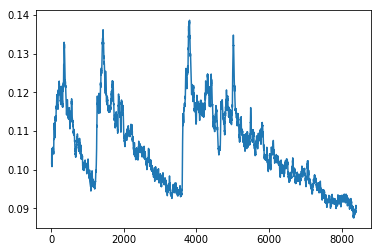

In [97]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [9]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

This took ~20 minutes

In [12]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

Save out using
```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

In [100]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

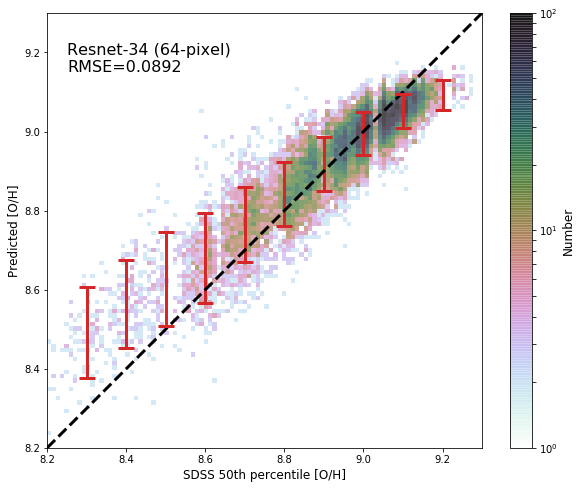

In [101]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS 12 + log(O/H)', fontsize=12)
ax.set_ylabel('Predicted 12 + log(O/H)', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')

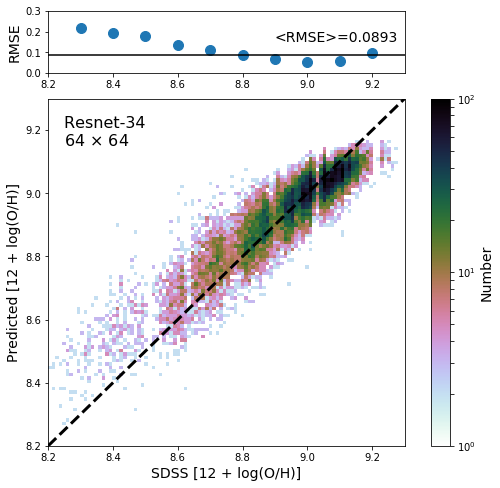

In [149]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 32 x 32 $gri$ imaging

In [14]:
sz = 32
bs = 128
arch = resnet34

In [15]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.156711   0.141361  
    1      0.145207   0.133021                                 



epoch      trn_loss   val_loss                                 
    0      0.130549   0.12617   



epoch      trn_loss   val_loss                                 
    0      0.101018   0.096751  
    1      0.110522   0.105073                                 
    2      0.099392   0.094615                                  
    3      0.126136   0.109628                                 
    4      0.108735   0.103027                                 
    5      0.100205   0.092346                                  
    6      0.099108   0.091998                                  



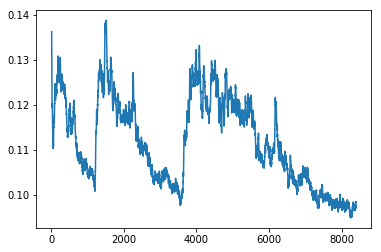

In [91]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [16]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

And that took ~15 minutes

In [17]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

```
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

In [94]:
y_bins = np.linspace(8.3, 9.2, 10)
p_means = [np.mean(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]
p_stds = [np.std(p_test.flat[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)]) for y in y_bins]

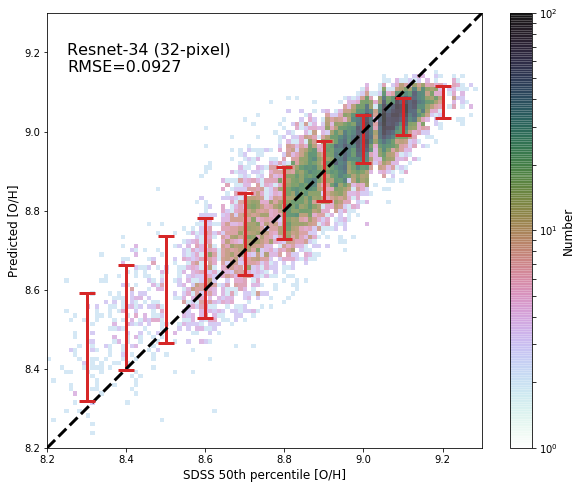

In [95]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=0.7)
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
ax.set_aspect(aspect='equal')

# bins
ax.errorbar(y_bins, p_means, yerr=p_stds, c='C3', ls='', lw=3, capsize=8, capthick=3)

ax.text(8.25, 9.15, f'Resnet-34 ({sz}-pixel) \n' f'RMSE={rms_errors:.4f}', fontsize=16)

ax.set_xlabel('SDSS 50th percentile [O/H]', fontsize=12)
ax.set_ylabel('Predicted [O/H]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)

fig.savefig(f'{PATH}/results/single-sz{sz}_pred-vs-SDSS.pdf')

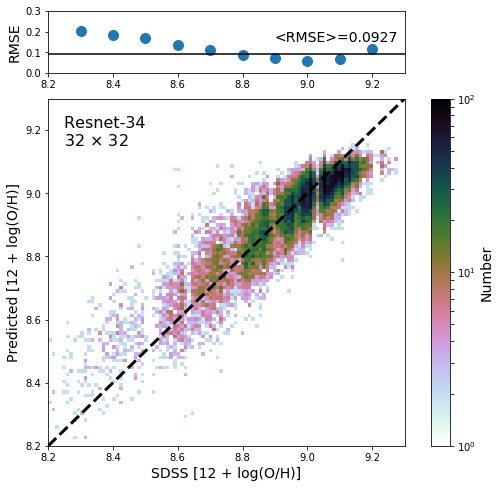

In [154]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 16 x 16 $gri$ imaging

In [19]:
sz = 16
bs = 128
arch = resnet34

In [20]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.139852   0.127485  
    1      0.144959   0.130074                                 



epoch      trn_loss   val_loss                                 
    0      0.139093   0.117961  



epoch      trn_loss   val_loss                                 
    0      0.110246   0.106782  
    1      0.125922   0.148304                                 
    2      0.108648   0.105661                                 
    3      0.124388   0.184522                                 
    4      0.117913   0.105993                                 
    5      0.112469   0.107288                                 
    6      0.107787   0.104377                                 



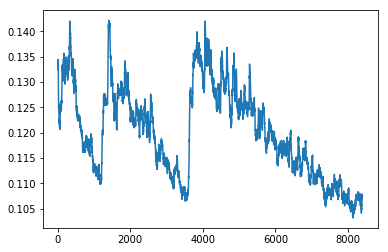

In [21]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [23]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

In [22]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

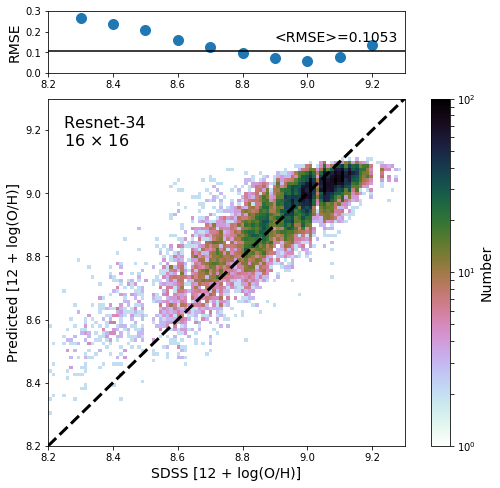

In [27]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 8 x 8 $gri$ imaging

In [28]:
sz = 8
bs = 128
arch = resnet34

In [29]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.146071   0.140849  
    1      0.138899   0.129544                                 



epoch      trn_loss   val_loss                                 
    0      0.14546    0.159402  



epoch      trn_loss   val_loss                                 
    0      0.117195   0.115187  
    1      0.128401   0.146518                                 
    2      0.117488   0.111976                                 
    3      0.131917   0.157765                                 
    4      0.123964   0.157868                                 
    5      0.117739   0.11413                                  
    6      0.114705   0.110781                                 



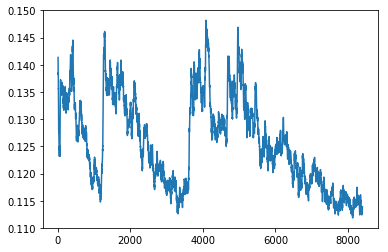

In [30]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [31]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

In [32]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

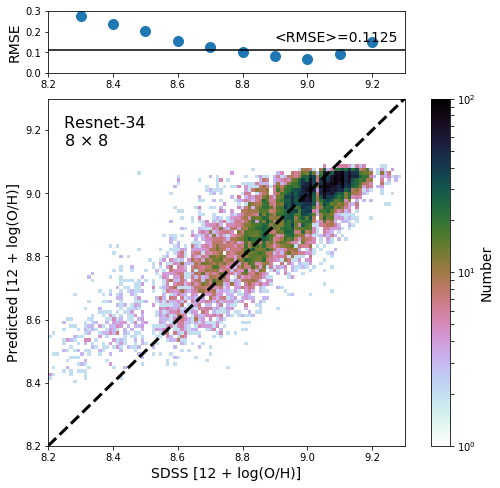

In [34]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 4 x 4 $gri$ imaging

In [35]:
sz = 4
bs = 128
arch = resnet34

In [36]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.154207   0.152578  
    1      0.16323    0.160614                                 



epoch      trn_loss   val_loss                                 
    0      0.14927    0.235215  



epoch      trn_loss   val_loss                                 
    0      0.130616   0.12929   
    1      0.137291   0.131105                                 
    2      0.129169   0.128531                                 
    3      0.151694   0.140153                                 
    4      0.137874   0.202706                                 
    5      0.134451   0.130352                                 
    6      0.129275   0.127508                                 



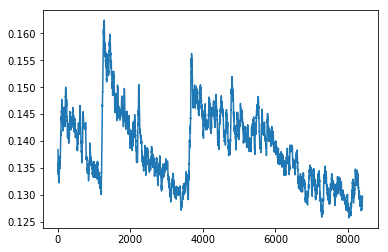

In [37]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [38]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

In [39]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

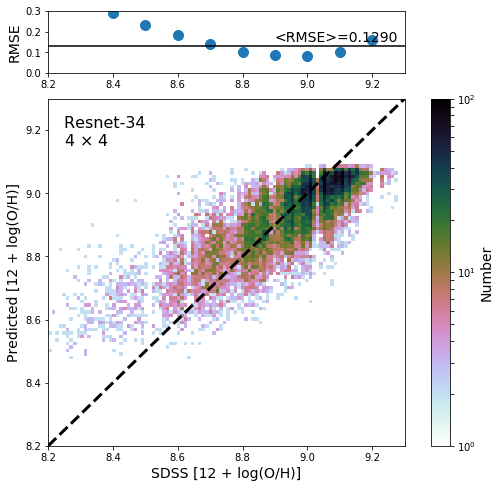

In [41]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 2 x 2 imaging

In [48]:
sz = 2
bs = 128
arch = resnet34

In [49]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.183065   0.176388  
    1      0.172822   0.167727                                 



epoch      trn_loss   val_loss                                 
    0      0.169565   0.196872  



epoch      trn_loss   val_loss                                 
    0      0.159429   0.156651  
    1      0.162974   0.164867                                 
    2      0.157919   0.156282                                 
    3      0.167491   0.178353                                 
    4      0.163944   0.196259                                 
    5      0.160554   0.160508                                 
    6      0.158651   0.156576                                 



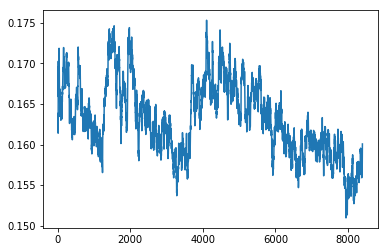

In [50]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [51]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

In [52]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))

```
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

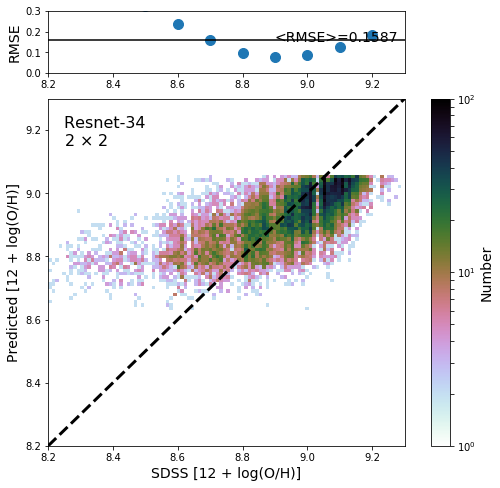

In [53]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)

# 1 x 1 "images"

In [55]:
sz = 1
bs = 128
arch = resnet34

In [56]:
val_idxs = get_cv_idxs(n)
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.181455   0.184878  
    1      0.179806   0.178735                                 



epoch      trn_loss   val_loss                                 
    0      0.171572   0.209397  



epoch      trn_loss   val_loss                                 
    0      0.163682   0.157164  
    1      0.164782   0.206885                                 
    2      0.160182   0.161719                                 
    3      0.16861    0.189617                                 
    4      0.166795   0.162721                                 
    5      0.160603   0.158978                                 
    6      0.157725   0.159085                                 



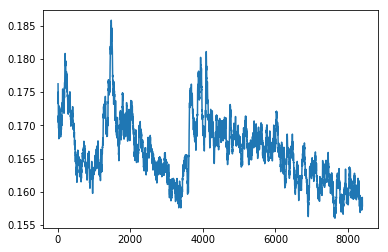

In [44]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [57]:
#learn.save(f'resnet34-single_sz{sz}-bs{bs}')
learn.load(f'resnet34-single_sz{sz}-bs{bs}')

In [58]:
preds, _ = learn.TTA(is_test=True)
p_test = preds.mean(axis=0)

rms_errors = np.sqrt(np.mean((p_test - y_test)**2))


```python
predicted = df_test.loc[test_names].copy()
predicted['prediction'] = p_test

predicted.to_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv')
```

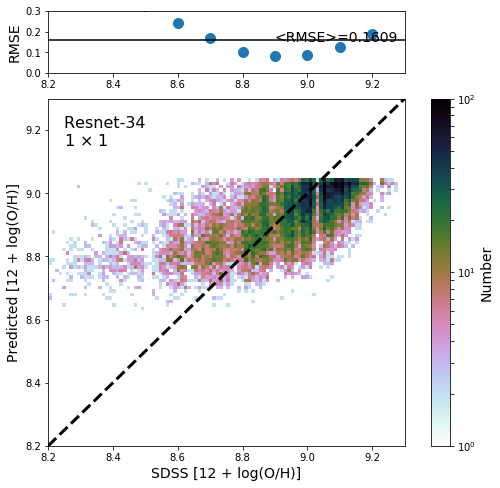

In [47]:
plot_comparison_with_marginals(y_test, p_test, rms_errors=rms_errors)